### Library

In [1]:
import os
import time
import random
import timm
import torch
import cv2
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shutil
import wandb
warnings.filterwarnings('ignore')

from albumentations import Compose, RandomBrightnessContrast, Blur, ShiftScaleRotate, GaussNoise, RandomGamma, CLAHE
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [2]:
def random_seed(SEED=42):
    # SEED = 42 # default
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True

random_seed()

### Load Data

In [3]:
train_label_path = "../../data/train.csv"
meta_data_path = "../../data/meta.csv"

train_df = pd.read_csv(train_label_path)
meta_data = pd.read_csv(meta_data_path)
train_df

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
1565,fed9e9ec4a77bc06.jpg,4
1566,feeade617aa68c45.jpg,7
1567,ff51dd281a8423f1.jpg,11
1568,ff8a6a251ce51c95.jpg,5


In [4]:
# Count_plot
def count_plot(df, col, figsize=(10, 6), palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel='Count'):
    plt.figure(figsize=figsize)
    sns.countplot(data=df, x=col, palette=palette)
    plt.title(title if title else f'{col} Count')
    plt.xticks(rotation=rotation)
    plt.xlabel(xlabel if xlabel is not None else col)
    plt.ylabel(ylabel)
    plt.show()

# hist plot
def hist_plot(df1, col, df2=None, figsize=(8, 6), bins=30, alpha=0.6, 
              color1='skyblue', color2='salmon', label1=None, label2=None, 
              title=None, density=False):
    plt.figure(figsize=figsize)
    
    stat_mode = 'density' if density else 'count'

    sns.histplot(df1[col], kde=True, bins=bins, alpha=alpha, color=color1, 
                 stat=stat_mode, label=label1 if label1 else ('Group 1' if df2 is not None else None))
    
    if df2 is not None:
        sns.histplot(df2[col], kde=True, bins=bins, alpha=alpha, color=color2, 
                     stat=stat_mode, label=label2 if label2 else 'Group 2')
        plt.legend()

    plt.title(title if title else f'{col} Distribution ({"Density" if density else "Count"} Histogram + KDE)')
    plt.xlabel(col)
    plt.ylabel("Density" if density else "Count")
    plt.show()

# bar plot    
def bar_plot(df, x_col, y_col, figsize=(10, 6), hue=None, palette="Blues_r", rotation=None, title=None, xlabel=None, ylabel=None):
     plt.figure(figsize=figsize)
     
     if hue: # hue 지정
        sns.barplot(x=x_col, y=y_col, hue=hue, data=df, palette=palette)
     else: # hue 지정 X
        sns.barplot(x=x_col, y=y_col, data=df, palette=palette)

     plt.xticks(rotation=rotation)
     plt.title(title)
     plt.xlabel(xlabel)
     plt.ylabel(ylabel)
     plt.show()

# heatmap
def heat_map(df, target_col=None, figsize=(8, 10), threshold=0, cmap='Reds', method='pearson', annot_kws=None, return_data=False):
        df = df.select_dtypes(include=['number'])
        
        if annot_kws is None:
            annot_kws = {"size": 10}

        if target_col is not None:
            corr_series = df.corr(method=method)[target_col].drop(target_col)
            corr_filtered = corr_series[abs(corr_series) >= threshold].sort_values(ascending=False)

            plt.figure(figsize=figsize)
            sns.heatmap(corr_filtered.to_frame(name='Correlation'), annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation with {target_col}', fontsize=14)
            plt.show()

            corr_df = corr_filtered.reset_index()
            corr_df.columns = ['Variable', 'Correlation']

            if return_data:
                return corr_df

        else:
            corr_matrix = df.corr(method=method) # 전체 변수 간 상관계수

            plt.figure(figsize=figsize)
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap=cmap, annot_kws=annot_kws, cbar=True)
            plt.title(f'{method.capitalize()} Correlation Matrix (All Variables)', fontsize=14)
            plt.show()

            if return_data:
                return corr_matrix

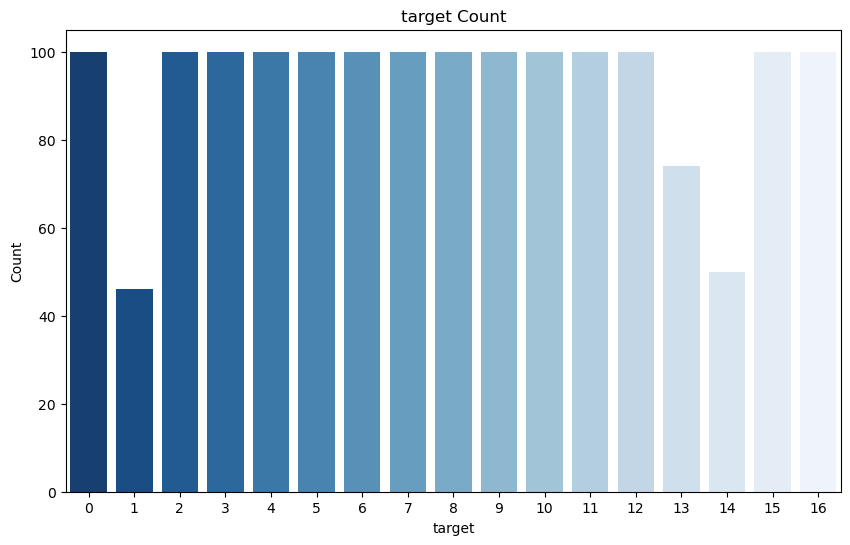

In [5]:
# Class check
count_plot(df=train_df, col='target')

### Preprocessing

In [6]:
def augment_image(train_df, train_path, save_dir, augmentation, classes):
    os.makedirs(save_dir, exist_ok=True)
    augmented_records = []

    for target_class, target_count in classes.items():
        current_count = len(train_df[train_df["target"] == target_class])
        if current_count >= target_count:
            continue

        n_to_augment = target_count - current_count
        samples = train_df[train_df["target"] == target_class]

        print(f"[INFO] Class {target_class}: 증강 {n_to_augment}개 생성 중...")
        for i in tqdm(range(n_to_augment)):
            sample_row = samples.sample(1).iloc[0]
            img_name = sample_row['ID']
            img_path = os.path.join(train_path, img_name)
            true_target = sample_row['target']

            img = cv2.imread(img_path)
            if img is None:
                print(f"[경고] 이미지 로드 실패: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            augmented = augmentation(image=img)['image']

            aug_name = f"aug_class{true_target}_{i}_{img_name}"
            aug_path = os.path.join(save_dir, aug_name)
            cv2.imwrite(aug_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

            # 실제 저장 여부를 확인
            if not os.path.exists(aug_path):
                print(f"[에러] 증강 이미지 저장 실패: {aug_path}")
                continue

            # 디버그용: 증강 대상 및 경로 출력
            if i < 3 or i % 50 == 0:
                pass
                # print(f"[디버그] Target={true_target}, Saved: {aug_path}")

            augmented_records.append({"ID": aug_name, "target": true_target})

    aug_df = pd.DataFrame(augmented_records)
    aug_df.to_csv("../../data/augmented.csv", index=False)
    print("[완료] 증강 데이터 생성 및 레이블 저장 완료")

In [7]:
augmentation = A.Compose([
    A.RandomBrightnessContrast(limit=0.1, p=0.3),  # 밝기 & 대비: limit 줄이고 확률 30%
    A.Blur(blur_limit=2, p=0.2),                  # 블러: 흐림 강도 크게 낮추고 확률 10%
    A.ShiftScaleRotate(                            # 이동/스케일/회전: 범위 축소 & 확률 20%
        shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.2
    ),
    A.OneOf([                                      # 테스트셋처럼 강한 회전/반전 케이스 생성
        A.Rotate(limit=[-90, 90], p=0.2),          # ±90도까지 강한 회전 허용
        A.HorizontalFlip(p=0.2),                   # 좌우 반전
        A.VerticalFlip(p=0.1),                     # 상하 반전
    ], p=0.3),                                     # 위 셋 중 하나를 30% 확률로 적용

    # A.GaussNoise(var_limit=(0.001, 0.01), mean=0, p=0.05),     # 노이즈: 강도 크게 낮추고 확률 10%
    A.RandomGamma(gamma_limit=(95, 105), p=0.2),   # 감마: 조정 범위를 매우 좁게
    A.CLAHE(clip_limit=1.5, p=0.2),                # CLAHE: 대비 과도 상승 방지
])
save_dir="../../data/augmented_images"
classes={1: 100, 13: 100, 14: 100}
train_path = '../../data/train/'
test_path = '../../data/test/'

augment_image(train_df=train_df, train_path=train_path, save_dir=save_dir, augmentation=augmentation, classes=classes)

[INFO] Class 1: 증강 54개 생성 중...


100%|██████████| 54/54 [00:00<00:00, 204.27it/s]


[INFO] Class 13: 증강 26개 생성 중...


100%|██████████| 26/26 [00:00<00:00, 296.16it/s]


[INFO] Class 14: 증강 50개 생성 중...


100%|██████████| 50/50 [00:00<00:00, 302.53it/s]

[완료] 증강 데이터 생성 및 레이블 저장 완료


In [8]:
aug_df = pd.read_csv("../../data/augmented.csv")
train_dfs = pd.concat([train_df, aug_df], ignore_index=True)
train_dfs["full_path"] = train_dfs["ID"].apply(
    lambda x: os.path.join(
        "../../data/augmented_images" if x.startswith("aug_") else "../../data/train", x
    )
)
train_dfs

,ID,target,full_path
0,002f99746285dfdd.jpg,16,../../data/train/002f99746285dfdd.jpg
1,008ccd231e1fea5d.jpg,10,../../data/train/008ccd231e1fea5d.jpg
2,008f5911bfda7695.jpg,10,../../data/train/008f5911bfda7695.jpg
3,009235e4c9c07af5.jpg,4,../../data/train/009235e4c9c07af5.jpg
4,00b2f44967580c74.jpg,16,../../data/train/00b2f44967580c74.jpg
...,...,...,...
1695,aug_class14_45_76ff32bef566bd38.jpg,14,../../data/augmented_images/aug_class14_45_76f...
1696,aug_class14_46_c323c86de8033ad1.jpg,14,../../data/augmented_images/aug_class14_46_c32...
1697,aug_class14_47_706f88bd829080ed.jpg,14,../../data/augmented_images/aug_class14_47_706...
1698,aug_class14_48_80f998b8dd043ab3.jpg,14,../../data/augmented_images/aug_class14_48_80f...


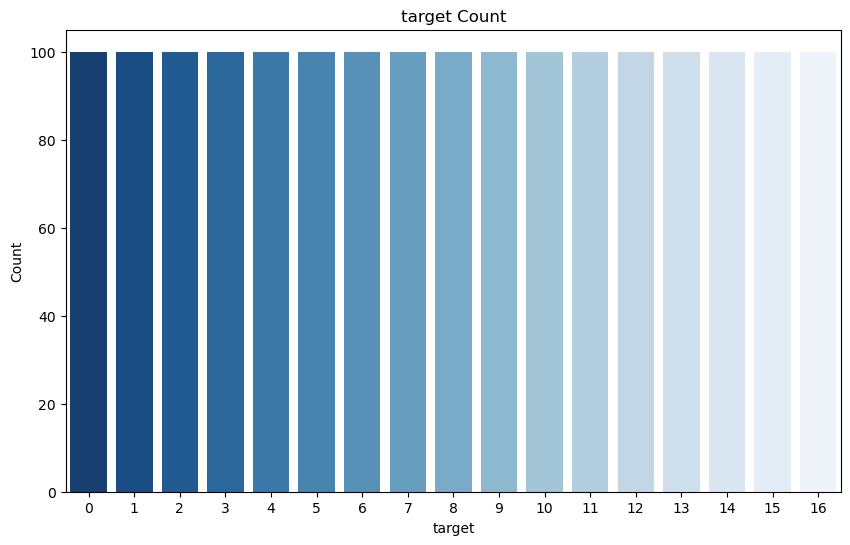

In [9]:
# Class check
count_plot(df=train_dfs, col='target')

In [10]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target, full_path = self.df[idx]  # 3개 컬럼 순서 주의
        img = np.array(Image.open(full_path))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "convnextv2_large.fcmae_ft_in22k_in1k"  
img_size = 256 
LR = 5e-5
EPOCHS = 60
BATCH_SIZE = 4
num_workers = 2 # GPU 사용

train_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

test_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),   # 1) 이미지 크기 통일
    A.Normalize(                                 # 2) 픽셀 정규화
        mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),                                # 3) 텐서 변환
])

In [12]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dfs, train_dfs['target'])):
    print(f"\n=== Fold {fold+1} ===")
    train_fold_df = train_dfs.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_dfs.iloc[val_idx].reset_index(drop=True)

    train_dataset = ImageDataset(train_fold_df, transform=train_transform)
    val_dataset = ImageDataset(val_fold_df, transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
    print(f"Fold {fold+1}: Train samples={len(train_fold_df)}, Val samples={len(val_fold_df)}")

    # 모델 정의
    model = timm.create_model(model_name, pretrained=True, num_classes=17, drop_path_rate=0.3).to(device) # drop_path_rate=0.2
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    best_f1 = -1.0
    patience = 5
    trigger = 0

    os.environ["WANDB_DIR"] = "../../"

    # WandB 초기화
    wandb.init(
        project="Document Classification",
        entity="moonstalker9010-none",
        name=f"fold_{fold+1}",
        config={
            "epochs": EPOCHS,
            "img_size": img_size,
            "batch_size": BATCH_SIZE,
            "learning_rate": LR,
            "model_name": model_name,
        }
    )

    for epoch in range(1, EPOCHS + 1):
        # 학습
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Training")
        for images, targets in train_bar:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)

        # 검증
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f"[Fold {fold+1}][Epoch {epoch}/{EPOCHS}] Validation")
            for images, targets in val_bar:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

                correct += (preds == targets).sum().item()
                total += targets.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        val_f1 = f1_score(all_targets, all_preds, average='macro')

        print(f"[F{fold+1}] Ep{epoch} - "
              f"Train: {avg_train_loss:.4f} | VaL: {avg_val_loss:.4f}, "
              f"Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # WandB 로깅
        wandb.log({
            "fold": fold + 1,
            "epoch": epoch,
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1,
        })

        # EarlyStopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            trigger = 0
            save_dir = "../../model"
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, f"model_fold{fold+1}.pth"))
        else:
            trigger += 1
            if trigger >= patience:
                print(f"[Fold {fold+1}] Early stopping triggered. Best F1: {best_f1:.4f}")
                break

    wandb.finish()


=== Fold 1 ===
Fold 1: Train samples=1360, Val samples=340


wandb: Currently logged in as: moonstalker9010 (moonstalker9010-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


[Fold 1][Epoch 1/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.43it/s]


[F1] Ep1 - Train: 0.8823 | VaL: 0.3146, Acc: 0.8853, F1: 0.8816


[Fold 1][Epoch 2/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.31it/s]


[F1] Ep2 - Train: 0.2241 | VaL: 0.2554, Acc: 0.8971, F1: 0.8848


[Fold 1][Epoch 3/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.61it/s]


[F1] Ep3 - Train: 0.1482 | VaL: 0.3541, Acc: 0.8824, F1: 0.8753


[Fold 1][Epoch 4/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.25it/s]


[F1] Ep4 - Train: 0.1114 | VaL: 0.2595, Acc: 0.9176, F1: 0.9168


[Fold 1][Epoch 5/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.10it/s]


[F1] Ep5 - Train: 0.0425 | VaL: 0.2564, Acc: 0.9206, F1: 0.9191


[Fold 1][Epoch 6/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.96it/s]


[F1] Ep6 - Train: 0.0509 | VaL: 0.3175, Acc: 0.9176, F1: 0.9130


[Fold 1][Epoch 7/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.36it/s]


[F1] Ep7 - Train: 0.0605 | VaL: 0.2390, Acc: 0.9324, F1: 0.9316


[Fold 1][Epoch 8/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.61it/s]


[F1] Ep8 - Train: 0.0402 | VaL: 0.3875, Acc: 0.9176, F1: 0.9157


[Fold 1][Epoch 9/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.08it/s]


[F1] Ep9 - Train: 0.0362 | VaL: 0.2101, Acc: 0.9235, F1: 0.9230


[Fold 1][Epoch 10/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.46it/s]


[F1] Ep10 - Train: 0.0168 | VaL: 0.3131, Acc: 0.9118, F1: 0.9098


[Fold 1][Epoch 11/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.44it/s]


[F1] Ep11 - Train: 0.0018 | VaL: 0.3051, Acc: 0.9324, F1: 0.9346


[Fold 1][Epoch 12/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.02it/s]


[F1] Ep12 - Train: 0.0015 | VaL: 0.4902, Acc: 0.9206, F1: 0.9152


[Fold 1][Epoch 13/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.65it/s]


[F1] Ep13 - Train: 0.1533 | VaL: 0.3871, Acc: 0.9206, F1: 0.9184


[Fold 1][Epoch 14/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.34it/s]


[F1] Ep14 - Train: 0.0445 | VaL: 0.2410, Acc: 0.9441, F1: 0.9435


[Fold 1][Epoch 15/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.37it/s]


[F1] Ep15 - Train: 0.0323 | VaL: 0.4074, Acc: 0.9235, F1: 0.9221


[Fold 1][Epoch 16/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.07it/s]


[F1] Ep16 - Train: 0.0061 | VaL: 0.3724, Acc: 0.9265, F1: 0.9264


[Fold 1][Epoch 17/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.99it/s]


[F1] Ep17 - Train: 0.0009 | VaL: 0.3832, Acc: 0.9382, F1: 0.9380


[Fold 1][Epoch 18/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.05it/s]


[F1] Ep18 - Train: 0.0003 | VaL: 0.3807, Acc: 0.9353, F1: 0.9359


[Fold 1][Epoch 19/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.23it/s]

[F1] Ep19 - Train: 0.0004 | VaL: 0.4184, Acc: 0.9294, F1: 0.9307
[Fold 1] Early stopping triggered. Best F1: 0.9435


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_acc,▁▃▁▅▅▅▇▅▆▄▇▅▅█▆▆▇▇▆
val_f1,▂▂▁▅▅▅▇▅▆▅▇▅▅█▆▆▇▇▇
val_loss,▄▂▅▂▂▄▂▅▁▄▃█▅▂▆▅▅▅▆
epoch,19
fold,1
train_loss,0.00039
val_acc,0.92941
val_f1,0.93071



=== Fold 2 ===
Fold 2: Train samples=1360, Val samples=340


[Fold 2][Epoch 1/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.85it/s]


[F2] Ep1 - Train: 0.8501 | VaL: 0.4286, Acc: 0.8559, F1: 0.8399


[Fold 2][Epoch 2/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.48it/s]


[F2] Ep2 - Train: 0.2342 | VaL: 0.2523, Acc: 0.9147, F1: 0.9107


[Fold 2][Epoch 3/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.51it/s]


[F2] Ep3 - Train: 0.1544 | VaL: 0.2219, Acc: 0.9265, F1: 0.9153


[Fold 2][Epoch 4/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.41it/s]


[F2] Ep4 - Train: 0.0837 | VaL: 0.1582, Acc: 0.9294, F1: 0.9255


[Fold 2][Epoch 5/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.60it/s]


[F2] Ep5 - Train: 0.0629 | VaL: 0.2662, Acc: 0.9294, F1: 0.9282


[Fold 2][Epoch 6/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.59it/s]


[F2] Ep6 - Train: 0.0676 | VaL: 0.2354, Acc: 0.9412, F1: 0.9393


[Fold 2][Epoch 7/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.12it/s]


[F2] Ep7 - Train: 0.0475 | VaL: 0.2435, Acc: 0.9353, F1: 0.9360


[Fold 2][Epoch 8/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.44it/s]


[F2] Ep8 - Train: 0.0474 | VaL: 0.2294, Acc: 0.9471, F1: 0.9470


[Fold 2][Epoch 9/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.32it/s]


[F2] Ep9 - Train: 0.0642 | VaL: 0.2943, Acc: 0.9088, F1: 0.9078


[Fold 2][Epoch 10/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.96it/s]


[F2] Ep10 - Train: 0.0388 | VaL: 0.3439, Acc: 0.9382, F1: 0.9316


[Fold 2][Epoch 11/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.32it/s]


[F2] Ep11 - Train: 0.0961 | VaL: 0.3034, Acc: 0.9324, F1: 0.9260


[Fold 2][Epoch 12/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.09it/s]


[F2] Ep12 - Train: 0.0414 | VaL: 0.2328, Acc: 0.9441, F1: 0.9452


[Fold 2][Epoch 13/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.10it/s]


[F2] Ep13 - Train: 0.0141 | VaL: 0.2358, Acc: 0.9529, F1: 0.9523


[Fold 2][Epoch 14/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.24it/s]


[F2] Ep14 - Train: 0.0033 | VaL: 0.2493, Acc: 0.9588, F1: 0.9584


[Fold 2][Epoch 15/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.43it/s]


[F2] Ep15 - Train: 0.0085 | VaL: 0.2385, Acc: 0.9618, F1: 0.9617


[Fold 2][Epoch 16/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.86it/s]


[F2] Ep16 - Train: 0.0006 | VaL: 0.2410, Acc: 0.9588, F1: 0.9581


[Fold 2][Epoch 17/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.96it/s]


[F2] Ep17 - Train: 0.0004 | VaL: 0.2507, Acc: 0.9559, F1: 0.9552


[Fold 2][Epoch 18/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.68it/s]


[F2] Ep18 - Train: 0.0044 | VaL: 0.2875, Acc: 0.9618, F1: 0.9614


[Fold 2][Epoch 19/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.27it/s]


[F2] Ep19 - Train: 0.0004 | VaL: 0.2931, Acc: 0.9618, F1: 0.9614


[Fold 2][Epoch 20/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.11it/s]

[F2] Ep20 - Train: 0.0052 | VaL: 0.2937, Acc: 0.9559, F1: 0.9552
[Fold 2] Early stopping triggered. Best F1: 0.9617


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▆▆▇▆▇▅▆▆▇▇███████
val_f1,▁▅▅▆▆▇▇▇▅▆▆▇▇███████
val_loss,█▃▃▁▄▃▃▃▅▆▅▃▃▃▃▃▃▄▄▅
epoch,20
fold,2
train_loss,0.00516
val_acc,0.95588
val_f1,0.95517



=== Fold 3 ===
Fold 3: Train samples=1360, Val samples=340


[Fold 3][Epoch 1/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.16it/s]


[F3] Ep1 - Train: 0.8671 | VaL: 0.2345, Acc: 0.9176, F1: 0.9117


[Fold 3][Epoch 2/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.84it/s]


[F3] Ep2 - Train: 0.2658 | VaL: 0.1600, Acc: 0.9382, F1: 0.9326


[Fold 3][Epoch 3/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.00it/s]


[F3] Ep3 - Train: 0.1456 | VaL: 0.1352, Acc: 0.9441, F1: 0.9367


[Fold 3][Epoch 4/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.61it/s]


[F3] Ep4 - Train: 0.1180 | VaL: 0.1544, Acc: 0.9412, F1: 0.9360


[Fold 3][Epoch 5/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.40it/s]


[F3] Ep5 - Train: 0.0977 | VaL: 0.1553, Acc: 0.9441, F1: 0.9414


[Fold 3][Epoch 6/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.07it/s]


[F3] Ep6 - Train: 0.0427 | VaL: 0.2202, Acc: 0.9441, F1: 0.9378


[Fold 3][Epoch 7/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.54it/s]


[F3] Ep7 - Train: 0.0473 | VaL: 0.2279, Acc: 0.9471, F1: 0.9430


[Fold 3][Epoch 8/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.86it/s]


[F3] Ep8 - Train: 0.0381 | VaL: 0.1515, Acc: 0.9529, F1: 0.9502


[Fold 3][Epoch 9/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.86it/s]


[F3] Ep9 - Train: 0.0191 | VaL: 0.1803, Acc: 0.9471, F1: 0.9445


[Fold 3][Epoch 10/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.49it/s]


[F3] Ep10 - Train: 0.0578 | VaL: 0.1859, Acc: 0.9588, F1: 0.9581


[Fold 3][Epoch 11/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.00it/s]


[F3] Ep11 - Train: 0.0648 | VaL: 0.2525, Acc: 0.9324, F1: 0.9262


[Fold 3][Epoch 12/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.52it/s]


[F3] Ep12 - Train: 0.0246 | VaL: 0.3006, Acc: 0.9500, F1: 0.9448


[Fold 3][Epoch 13/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.72it/s]


[F3] Ep13 - Train: 0.0061 | VaL: 0.3515, Acc: 0.9206, F1: 0.9201


[Fold 3][Epoch 14/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.24it/s]


[F3] Ep14 - Train: 0.0470 | VaL: 0.2395, Acc: 0.9471, F1: 0.9464


[Fold 3][Epoch 15/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.71it/s]

[F3] Ep15 - Train: 0.0262 | VaL: 0.3590, Acc: 0.9500, F1: 0.9441
[Fold 3] Early stopping triggered. Best F1: 0.9581


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▅▆▅▆▆▆▇▆█▄▇▂▆▇
val_f1,▁▄▅▅▅▅▆▇▆█▃▆▂▆▆
val_loss,▄▂▁▂▂▄▄▂▂▃▅▆█▄█
epoch,15
fold,3
train_loss,0.02624
val_acc,0.95
val_f1,0.94411



=== Fold 4 ===
Fold 4: Train samples=1360, Val samples=340


[Fold 4][Epoch 1/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.55it/s]


[F4] Ep1 - Train: 0.8493 | VaL: 0.2760, Acc: 0.8824, F1: 0.8855


[Fold 4][Epoch 2/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.94it/s]


[F4] Ep2 - Train: 0.2543 | VaL: 0.1807, Acc: 0.9324, F1: 0.9136


[Fold 4][Epoch 3/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.14it/s]


[F4] Ep3 - Train: 0.1444 | VaL: 0.1529, Acc: 0.9471, F1: 0.9406


[Fold 4][Epoch 4/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.27it/s]


[F4] Ep4 - Train: 0.0801 | VaL: 0.2341, Acc: 0.9088, F1: 0.9131


[Fold 4][Epoch 5/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.45it/s]


[F4] Ep5 - Train: 0.0869 | VaL: 0.2382, Acc: 0.9353, F1: 0.9172


[Fold 4][Epoch 6/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.41it/s]


[F4] Ep6 - Train: 0.0626 | VaL: 0.1326, Acc: 0.9500, F1: 0.9486


[Fold 4][Epoch 7/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.73it/s]


[F4] Ep7 - Train: 0.0404 | VaL: 0.1580, Acc: 0.9529, F1: 0.9518


[Fold 4][Epoch 8/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.69it/s]


[F4] Ep8 - Train: 0.0065 | VaL: 0.1232, Acc: 0.9676, F1: 0.9670


[Fold 4][Epoch 9/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.68it/s]


[F4] Ep9 - Train: 0.1247 | VaL: 0.2682, Acc: 0.9176, F1: 0.9097


[Fold 4][Epoch 10/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.25it/s]


[F4] Ep10 - Train: 0.0506 | VaL: 0.2743, Acc: 0.9441, F1: 0.9360


[Fold 4][Epoch 11/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.47it/s]


[F4] Ep11 - Train: 0.0175 | VaL: 0.2905, Acc: 0.9471, F1: 0.9397


[Fold 4][Epoch 12/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.55it/s]


[F4] Ep12 - Train: 0.0351 | VaL: 0.1714, Acc: 0.9382, F1: 0.9378


[Fold 4][Epoch 13/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.21it/s]

[F4] Ep13 - Train: 0.0398 | VaL: 0.2541, Acc: 0.9441, F1: 0.9412
[Fold 4] Early stopping triggered. Best F1: 0.9670


epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▂▁▁▁▁
val_acc,▁▅▆▃▅▇▇█▄▆▆▆▆
val_f1,▁▃▆▃▄▆▇█▃▅▆▅▆
val_loss,▇▃▂▆▆▁▂▁▇▇█▃▆
epoch,13
fold,4
train_loss,0.03982
val_acc,0.94412
val_f1,0.94121



=== Fold 5 ===
Fold 5: Train samples=1360, Val samples=340


[Fold 5][Epoch 1/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.94it/s]


[F5] Ep1 - Train: 1.2155 | VaL: 0.3419, Acc: 0.8559, F1: 0.8520


[Fold 5][Epoch 2/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.31it/s]


[F5] Ep2 - Train: 0.2538 | VaL: 0.2669, Acc: 0.9000, F1: 0.8924


[Fold 5][Epoch 3/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.88it/s]


[F5] Ep3 - Train: 0.1674 | VaL: 0.2792, Acc: 0.9000, F1: 0.8939


[Fold 5][Epoch 4/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.78it/s]


[F5] Ep4 - Train: 0.1299 | VaL: 0.2579, Acc: 0.8882, F1: 0.8877


[Fold 5][Epoch 5/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.97it/s]


[F5] Ep5 - Train: 0.0879 | VaL: 0.2133, Acc: 0.9412, F1: 0.9359


[Fold 5][Epoch 6/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.59it/s]


[F5] Ep6 - Train: 0.0471 | VaL: 0.2488, Acc: 0.9441, F1: 0.9411


[Fold 5][Epoch 7/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.64it/s]


[F5] Ep7 - Train: 0.0744 | VaL: 0.2710, Acc: 0.9294, F1: 0.9299


[Fold 5][Epoch 8/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.35it/s]


[F5] Ep8 - Train: 0.0609 | VaL: 0.2976, Acc: 0.9294, F1: 0.9293


[Fold 5][Epoch 9/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.23it/s]


[F5] Ep9 - Train: 0.0136 | VaL: 0.2837, Acc: 0.9500, F1: 0.9484


[Fold 5][Epoch 10/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.50it/s]


[F5] Ep10 - Train: 0.0015 | VaL: 0.2341, Acc: 0.9529, F1: 0.9531


[Fold 5][Epoch 11/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.85it/s]


[F5] Ep11 - Train: 0.0009 | VaL: 0.2294, Acc: 0.9529, F1: 0.9532


[Fold 5][Epoch 12/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.31it/s]


[F5] Ep12 - Train: 0.0007 | VaL: 0.3269, Acc: 0.9471, F1: 0.9462


[Fold 5][Epoch 13/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.56it/s]


[F5] Ep13 - Train: 0.0416 | VaL: 0.6529, Acc: 0.8676, F1: 0.8481


[Fold 5][Epoch 14/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.05it/s]


[F5] Ep14 - Train: 0.1022 | VaL: 0.4038, Acc: 0.9206, F1: 0.9175


[Fold 5][Epoch 15/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 27.29it/s]


[F5] Ep15 - Train: 0.0470 | VaL: 0.2045, Acc: 0.9471, F1: 0.9471


[Fold 5][Epoch 16/60] Validation: 100%|██████████| 85/85 [00:03<00:00, 26.89it/s]

[F5] Ep16 - Train: 0.0314 | VaL: 0.2617, Acc: 0.9471, F1: 0.9467
[Fold 5] Early stopping triggered. Best F1: 0.9532


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
fold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁
val_acc,▁▄▄▃▇▇▆▆████▂▆██
val_f1,▁▄▄▄▇▇▆▆████▁▆██
val_loss,▃▂▂▂▁▂▂▂▂▁▁▃█▄▁▂
epoch,16
fold,5
train_loss,0.03137
val_acc,0.94706
val_f1,0.9467


In [13]:
meta_data

,target,class_name
0,0,account_number
1,1,application_for_payment_of_pregnancy_medical_e...
2,2,car_dashboard
3,3,confirmation_of_admission_and_discharge
4,4,diagnosis
5,5,driver_lisence
6,6,medical_bill_receipts
7,7,medical_outpatient_certificate
8,8,national_id_card
9,9,passport


### Ensemble

In [15]:
class Image_Dataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 테스트셋: target 없으면 예외처리
        if self.df.shape[1] == 2:
            name, target = self.df[idx]
        else:
            name = self.df[idx][0]
            target = -1  # placeholder

        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [20]:
inference_path = "../../data/sample_submission.csv"
test_dataset = Image_Dataset(inference_path, test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

models = []
for fold in range(1, 6):
    model = timm.create_model(model_name, pretrained=False, num_classes=17, drop_path_rate=0.3).to(device)
    model.load_state_dict(torch.load(f"../../model/model_fold{fold}.pth"))
    model.eval()  # 추론 모드
    models.append(model)

In [21]:
models

[ConvNeXt(
   (stem): Sequential(
     (0): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
     (1): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
   )
   (stages): Sequential(
     (0): ConvNeXtStage(
       (downsample): Identity()
       (blocks): Sequential(
         (0): ConvNeXtBlock(
           (conv_dw): Conv2d(192, 192, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=192)
           (norm): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
           (mlp): GlobalResponseNormMlp(
             (fc1): Linear(in_features=192, out_features=768, bias=True)
             (act): GELU()
             (drop1): Dropout(p=0.0, inplace=False)
             (grn): GlobalResponseNorm()
             (fc2): Linear(in_features=768, out_features=192, bias=True)
             (drop2): Dropout(p=0.0, inplace=False)
           )
           (shortcut): Identity()
           (drop_path): Identity()
         )
         (1): ConvNeXtBlock(
           (conv_dw): Conv2d(192, 192, 

In [23]:
# 앙상블 WandB run
if wandb.run is not None:
    wandb.finish()

wandb.init(
    project="Document Classification",
    entity="moonstalker9010-none",
    name="ensemble_evaluation",
    config={
        "epochs": EPOCHS,
        "img_size": img_size,
        "batch_size": BATCH_SIZE,
        "learning_rate": LR,
        "model_name": model_name,
        "ensemble_models": len(models),
    }
)

oof_targets = []
oof_preds = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dfs, train_dfs['target'])):
    print(f"\n=== Fold {fold+1} Validation Inference ===")
    val_fold_df = train_dfs.iloc[val_idx].reset_index(drop=True)
    val_dataset = ImageDataset(val_fold_df, transform=test_transform)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

    fold_preds = []

    # 각 fold 검증셋을 앙상블 모델로 추론
    for model in models:
        model.eval()
        preds = []
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                outputs = model(images)
                probs = outputs.softmax(1).cpu().numpy()
                preds.append(probs)
        preds = np.concatenate(preds, axis=0)
        fold_preds.append(preds)

    # 앙상블 평균
    ensemble_probs = np.mean(fold_preds, axis=0)
    ensemble_preds = np.argmax(ensemble_probs, axis=1)

    # fold별 성능 기록
    fold_targets = val_fold_df["target"].values
    fold_f1 = f1_score(fold_targets, ensemble_preds, average="macro")
    fold_acc = accuracy_score(fold_targets, ensemble_preds)
    print(f"[Fold {fold+1}], F1: {fold_f1:.4f}, Acc: {fold_acc:.4f}")

    wandb.log({
        f"fold{fold+1}_f1": fold_f1,
        f"fold{fold+1}_acc": fold_acc,
    })

    oof_targets.extend(fold_targets)
    oof_preds.extend(ensemble_preds)

# 전체 OOF 성능 계산
oof_f1 = f1_score(oof_targets, oof_preds, average="macro")
oof_acc = accuracy_score(oof_targets, oof_preds)
print(f"\n=== OOF 앙상블 전체 성능: F1={oof_f1:.4f}, Acc={oof_acc:.4f} ===")

wandb.log({
    "ensemble_OOF_f1": oof_f1,
    "ensemble_OOF_acc": oof_acc,
})

wandb.finish()

BrokenPipeError: [Errno 32] Broken pipe

### Inference

In [19]:
all_preds = []

# 추론 시작
for model in models:
    model_preds = []
    with torch.no_grad(): 
        for images, _ in tqdm(test_loader, desc="Inference"):
            images = images.to(device)
            outputs = model(images)                # 로짓
            probs = torch.softmax(outputs, dim=1)  # 확률
            model_preds.append(probs.cpu().numpy())
    # 모델별 예측 shape: (num_samples, num_classes)
    all_preds.append(np.concatenate(model_preds, axis=0))

# 앙상블: 모델별 예측 평균
ensemble_preds = np.mean(all_preds, axis=0)   # shape: (num_samples, num_classes)
final_preds = np.argmax(ensemble_preds, axis=1)

# 저장
submission = pd.read_csv("../../data/sample_submission.csv")
submission["target"] = final_preds
submission.to_csv("../../data/submission.csv", index=False)

Inference: 100%|██████████| 785/785 [00:27<00:00, 28.40it/s]
